In [19]:
!curl {https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz} | tar xz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  2801k      0  0:00:29  0:00:29 --:--:-- 2661k


In [20]:
import string
import os

import pandas as pd
from pandas import to_pickle, read_pickle
from sklearn.metrics import accuracy_score, \
    precision_score, \
    recall_score, \
    ConfusionMatrixDisplay, \
    f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import re
import matplotlib.pyplot as plt

In [21]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/seijuroseta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/seijuroseta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
def get_data(data_dir):
    texts = []
    labels_index = {'pos':1, 'neg':0}
    tone = []
    score = []
    for name in sorted(os.listdir(data_dir)):
        path = os.path.join(data_dir, name)
        if os.path.isdir(path):
            if name=='pos' or name=='neg':
                label_id = labels_index[name]
                for fname in sorted(os.listdir(path)):
                        fpath = os.path.join(path, fname)
                        text = open(fpath,encoding='utf8').read()
                        texts.append(text)
                        tone.append(label_id)
                        score.append(re.search("_(\d+)",fname)[1])
    return texts, tone, score

X_train, y1_tone_train, y2_score_train = get_data('aclImdb/train')
X_test, y1_tone_test, y2_score_test = get_data('aclImdb/test')

In [23]:
print(X_train[24990])
print(y1_tone_train[24990])
print(y2_score_train[24990])

The most hillarious and funny Brooks movie I ever seen. I can watch and re-watch the tape 100 times. I laugh my a** off and I cry on some moments. It is really good and funny movie, and if you like Brooks - this is a must! In short - Brooks (billionare) gets to the streets as homeless for 30 days in order to win the entire poor district from his competitor. The reality bites, but in the end - it is about warm relations between humans... Hightly recommend!
1
10


In [24]:
stemmer = SnowballStemmer(language="english")
stop_words = stopwords.words("english")

def review_to_tokens(review):
    tokens = word_tokenize(review, language="english")
    tokens = [i for i in tokens if i not in string.punctuation]
    tokens = [i for i in tokens if i not in stop_words]
    tokens = [stemmer.stem(i) for i  in tokens]
    return tokens

In [25]:
vectorizer = TfidfVectorizer(tokenizer=review_to_tokens)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [26]:
tone_classifier = LogisticRegression(penalty="l2", random_state=42, C=1.2, solver="saga")
tone_model = tone_classifier.fit(X_train, y1_tone_train)
y1_tone_pred = tone_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

Precision: 0.881457749299159
Recall: 0.8804
Accuracy: 0.881


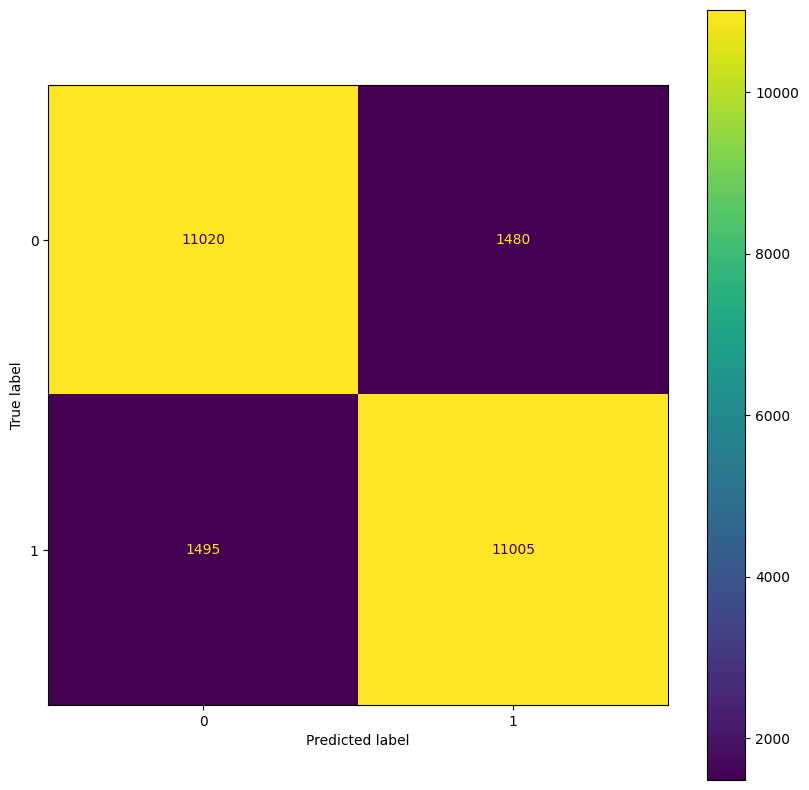

In [27]:
import scikitplot as skplt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

print(classification_report(y_true=y1_tone_test, y_pred=y1_tone_pred))
print(f'Precision: {precision_score(y_true=y1_tone_test, y_pred=y1_tone_pred)}')
print(f'Recall: {recall_score(y_true=y1_tone_test, y_pred=y1_tone_pred)}')
print(f'Accuracy: {accuracy_score(y_true=y1_tone_test, y_pred=y1_tone_pred)}')

_, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(y_true=y1_tone_test, y_pred=y1_tone_pred, ax=ax)
plt.show()

/home/seijuroseta/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


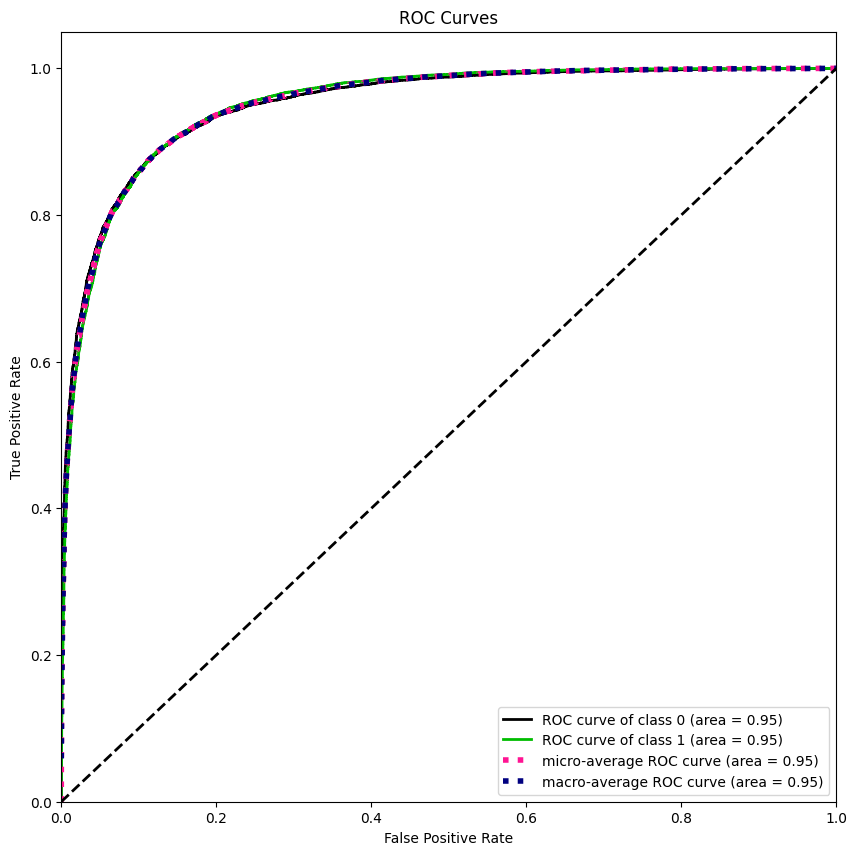

In [28]:
y_probas = tone_model.predict_proba(X_test)

_, ax = plt.subplots(figsize=(10,10))
skplt.metrics.plot_roc_curve(y1_tone_test, y_probas, ax=ax)
plt.show()

In [29]:
temp_score = y2_score_train

def cut_n (y_train, n, target):
    target_indxs = []
    for i in range(len(y_train)):
        if int(y2_score_train[i]) == target:
            target_indxs.append(i)
    return target_indxs[n:]

indxs = [*cut_n(y2_score_train, 3000, 10), *cut_n(y2_score_train, 3000, 1)]

/tmp/ipykernel_5349/734455946.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=y2_score_train,


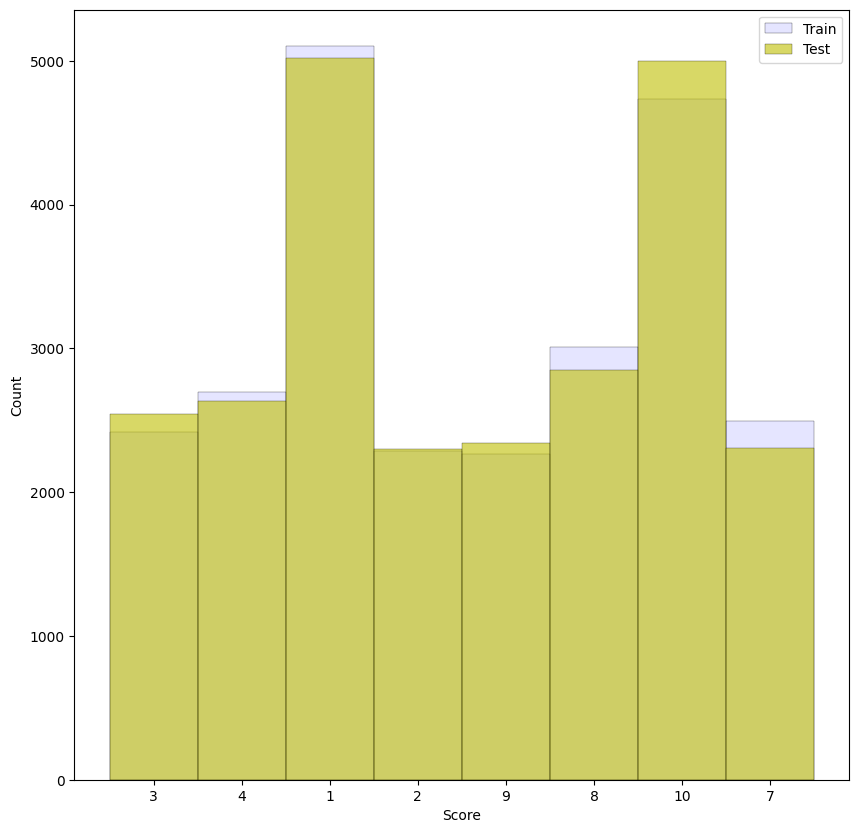

In [30]:
import seaborn as sns

sns.histplot(data=y2_score_train,
            fill=True,
            alpha=0.1,
            palette="crest",
            color="b",
            linewidth=0.2
             )
sns.histplot(data=y2_score_test,
            fill=True,
            alpha=0.6,
            color="y",
            linewidth=0.2
             )
plt.legend(["Train", "Test"])
plt.xlabel("Score")
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

In [31]:
from sklearn.metrics import log_loss
from sklearn.svm import SVC
score_classifier = LogisticRegression(penalty="l2", random_state=42, C=1, solver="saga")
#score_classifier = SVC(kernel="linear", C=1.5, random_state=42)
score_model = score_classifier.fit(X_train, y2_score_train)
y2_score_pred = score_model.predict(X_test)

0.44204


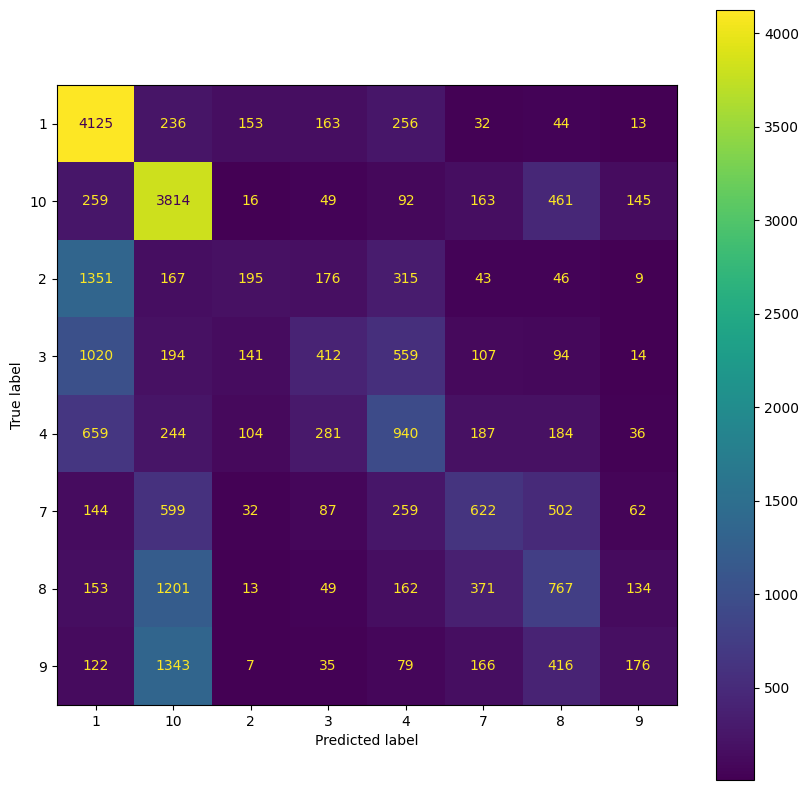

In [32]:
print(f1_score(y_true=y2_score_test, y_pred=y2_score_pred, average="micro"))
ConfusionMatrixDisplay.from_predictions(y_true=y2_score_test, y_pred=y2_score_pred)
plt.show()

In [33]:
to_pickle(vectorizer.vocabulary_, "./ml-prediction/models/vect_vocab.pkl")
to_pickle(tone_model, "./ml-prediction/models/tone_model.pkl")
to_pickle(score_model, "./ml-prediction/models/score_model.pkl")

In [34]:
print(score_model.predict(vectorizer.transform(["Great!", "Bad!"])))

['10' '1']


0.8119551100096347


/home/seijuroseta/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


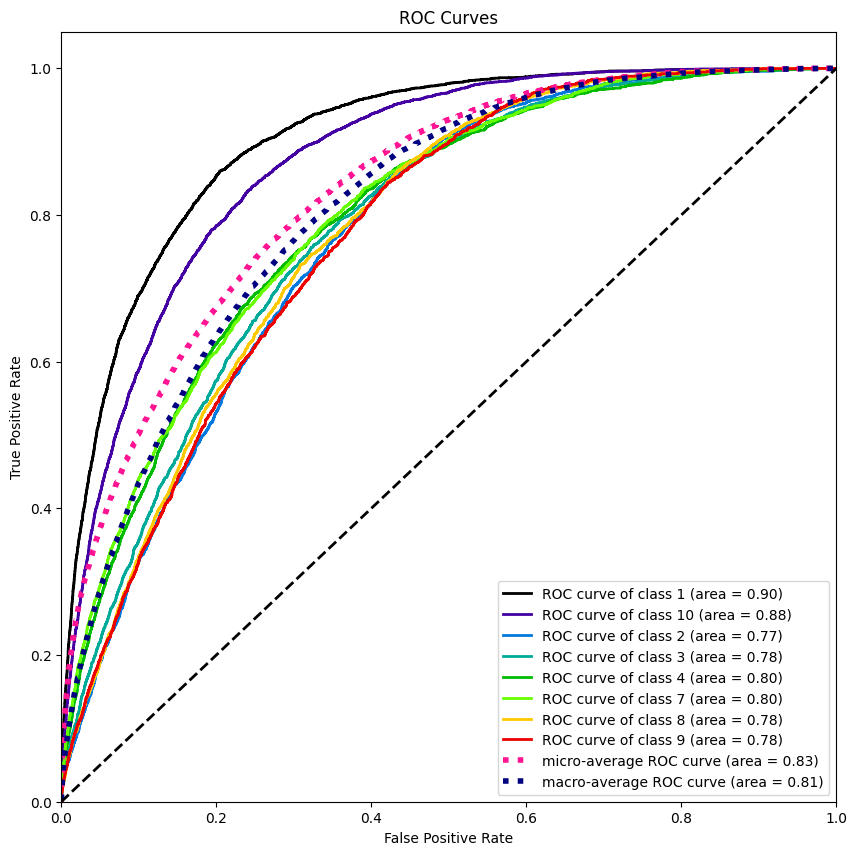

In [35]:
import scikitplot as skplt
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_true=y2_score_test, y_score=score_model.predict_proba(X_test), multi_class='ovr'))
y_true = y2_score_test
y_probas = score_model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.show()